#### 한국어 코퍼스 전처리 (*Torchtext 없이 해보기)
- 데이터셋 : Korpora에서 로딩
- 형태소분석기 설정
- 단어사전 생성

[1] 모듈 로딩 및 데이터 준비 <HR>

In [1]:
## 모듈 로딩
from Korpora import Korpora                         # Open Korean Dataset
from konlpy.tag import *                            # 형태소 분석기
import spacy                                        # 형태소 분석기

from nltk.tokenize import word_tokenize, sent_tokenize, wordpunct_tokenize
from torch.utils.data import Dataset, DataLoader    # Pytorch Dataset 관련 모듈
from nltk.corpus import stopwords
import pandas as pd
import numpy as np

In [2]:
### 데이터 로딩
nsmc = Korpora.load('nsmc')


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `nsmc` is already installed at C:\Users\KDP-50\Korpora\nsmc\ratings_train.txt
[Korpora] Corpus `nsmc` is already installed at C:\Users\KD

In [3]:
# Test 데이터셋을 DataFrame으로 로딩
nsmcDF = pd.DataFrame(nsmc.test)
nsmcDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


[3] 텍스트 데이터 전처리 <hr>
- 토큰화 / 정제 (불용어, 구두점, 띄어쓰기, 오타 등등 처리)
- 단어사전 생성
- 문장 ==> 수치화

In [4]:
### 형태소 분석기
# # 한나눔
# han = Hannanum()

# # 꼬꼬마
# kkma = Kkma()

# # OKT
# okt = Okt()

## 언어 모델 설정
KO_MODEL = 'ko_core_news_sm'

### 한국어 분석기 생성
nlp = spacy.load(KO_MODEL)

- 불용어 & 구두점 제거

In [5]:
import re
import string
punc = string.punctuation

In [6]:
STOP_PATH = '../Data/stopwords-ko.txt'
with open(STOP_PATH, 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

In [7]:
# 한국어 불용어 제거
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

In [8]:
class TextDataset(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label
        self.n_rows = feature.shape[0]

    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        return self.feature.iloc[index], self.label.iloc[index]

In [32]:
nsmcDS = TextDataset(nsmcDF['text'][:1000], nsmcDF['label'][:1000])

In [33]:
def generateToken(dataset):
    for text, label in dataset:
        token_list = []
        doc = nlp(text)

        for token in doc:
            if (not token.is_punct) and (not token.is_stop):
                token = re.sub('[^가-힣]','',str(token))
                if len(token): token_list.append(str(token))
        yield token_list

In [62]:
token_generator = generateToken(nsmcDS)

In [35]:
i = 0

for token_list in token_generator:
    i += 1
    for token in token_list:
        print(repr(token))
    if i == 5:
        break

'굳'
'뭐야'
'평점들은'
'나쁘진'
'않지만'
'점'
'짜리는'
'더더욱'
'아니잖아'
'지루하지는'
'않은데'
'완전'
'막장임'
'돈주고'
'보기에는'
'만'
'아니었어도'
'별'
'다섯'
'개'
'줬을텐데'
'왜'
'로'
'나와서'
'제'
'심기를'
'불편하게'
'하죠'


- 단어별 빈도수 계산

In [36]:
# 토큰을 키로 해서 빈도수 저장
token_freq={} # dict에서는 key값을 찾아봄

# 라인(줄)별 토큰을 읽어서 빈도 체크
for tokenList in token_generator:
    for token in tokenList:
        # 카운트시, 토큰 key가 존재하지 않으면 key 추가
        if token not in token_freq:
            token_freq[token] = 1
        # 카운트시, 이미 존재하는 토큰 key는 1 증가
        else:
            token_freq[token] += 1
# print(token_freq)

In [37]:
i = 0
for _ in token_freq:
    print(_)
    i += 1
    if i == 50:
        break

음악이
주가
된
최고의
음악영화
진정한
쓰레기
마치
미국애니에서
튀어나온듯한
창의력없는
로봇디자인부터가
고개를
젖게한다
갈수록
개판되가는
중국영화
유치하고
내용없음
폼잡다
끝남
말도안되는
무기에
유치한남무
아
그립다
동사서독같은
영화가
이건
류아류작이다
이별의
아픔뒤에
찾아오는
새로운
인연의
기쁨
모든
사람이
그렇지는
않네
괜찮네요오랜만포켓몬스터잼밌어요
한국독립영화의
한계
그렇게
아버지가
된다와
비교됨
청춘은
아름답다
아름다움은


In [38]:
# 단어들 별로 빈도수 저장
freqsDict={}
for k, v in token_freq.items():
    if v not in freqsDict:
        freqsDict[v]=[k]
    else:
        freqsDict[v].append(k)
print(freqsDict)

{2: ['음악이', '진정한', '갈수록', '내용없음', '끝남', '그립다', '수채화같은', '평을', '평점은', '뭐냐', '못보겠다', '함께', '잔인하고', '영화였다', '일본', '봤네', '딱', '했음', '한테', '밖에', '엉성한', '아깝고', '우리의', '마이너스', '감동적이다', '멜로를', '액션영화', '제임스', '먹고', '액션은', '년도', '때가', '재밌던데', '좋고', '생각나는', '으', '정도', '진짜로', '잘봤습니다', '결말', '지나치게', '되지', '말고', '했다', '지나친', '모든걸', '생긴', '연출력', '빵점', '작은', '거', '좋아', '볼만함', '제시카', '만나', '년', '명연기', '또한', '물론', '재미있었다', '긴', '탐험', '억지스런', '단', '여자들', '맥', '톰', '다시보는', '화려하고', '것을', '재밌어서', '모르고', '이제서야', '아쉽다', '단순', '어색한', '여기서', '노잼', '실제', '영상과', '표현되는', '차인표', '확실히', '재밌고', '뛰어난', '신선한', '소재로', '다시봐도', '잭', '여기', '느꼈던', '음악도', '잘하고', '통해', '책을', '못한', '웃기고', '인물', '짧은', '사람들의', '연기는', '실제로', '엉엉', '행복한', '어지럽고', '지루함의', '다보고', '제발', '박수를', '수준의', '년도에', '수작이다', '미국', '살렸다', '년이', '탕웨이', '이제껏', '너무좋다', '유쾌하게', '필요한가', '아마', '또는', '생각을', '본지', '삶은', '그저', '하나씩', '까지', '이야', '케이블에서', '심심할때', '수고', '한회', '생각도', '점도', '전작에', '훨씬', '찍어', '뭐가', '진수', '기억이', '싶습니다', '어색하고', '무엇인지', '그런가', '애니', '잼슴', '좋음

In [39]:
# 단어등장 횟수, 단어 개수 및 단어이름 별로 빈도수 저장
freqsDict={}
for k, v in token_freq.items():
    if v not in freqsDict:
        # freqsDict[v]=[k]
        # freqsDict[v]=1
        freqsDict[v]=[1, [k]]
    else:
        # freqsDict[v].append(k)
        # freqsDict[v]+=1
        freqsDict[v][0]+=1
        freqsDict[v][1].append(k)
print(freqsDict)

{2: [414, ['음악이', '진정한', '갈수록', '내용없음', '끝남', '그립다', '수채화같은', '평을', '평점은', '뭐냐', '못보겠다', '함께', '잔인하고', '영화였다', '일본', '봤네', '딱', '했음', '한테', '밖에', '엉성한', '아깝고', '우리의', '마이너스', '감동적이다', '멜로를', '액션영화', '제임스', '먹고', '액션은', '년도', '때가', '재밌던데', '좋고', '생각나는', '으', '정도', '진짜로', '잘봤습니다', '결말', '지나치게', '되지', '말고', '했다', '지나친', '모든걸', '생긴', '연출력', '빵점', '작은', '거', '좋아', '볼만함', '제시카', '만나', '년', '명연기', '또한', '물론', '재미있었다', '긴', '탐험', '억지스런', '단', '여자들', '맥', '톰', '다시보는', '화려하고', '것을', '재밌어서', '모르고', '이제서야', '아쉽다', '단순', '어색한', '여기서', '노잼', '실제', '영상과', '표현되는', '차인표', '확실히', '재밌고', '뛰어난', '신선한', '소재로', '다시봐도', '잭', '여기', '느꼈던', '음악도', '잘하고', '통해', '책을', '못한', '웃기고', '인물', '짧은', '사람들의', '연기는', '실제로', '엉엉', '행복한', '어지럽고', '지루함의', '다보고', '제발', '박수를', '수준의', '년도에', '수작이다', '미국', '살렸다', '년이', '탕웨이', '이제껏', '너무좋다', '유쾌하게', '필요한가', '아마', '또는', '생각을', '본지', '삶은', '그저', '하나씩', '까지', '이야', '케이블에서', '심심할때', '수고', '한회', '생각도', '점도', '전작에', '훨씬', '찍어', '뭐가', '진수', '기억이', '싶습니다', '어색하고', '무엇인지', '그런가', '애니', '잼슴

In [40]:
# [(단어나온 횟수, [단어개수, [단어이름]]) ...]
sorted(freqsDict.items(), reverse=True)

[(128, [1, ['영화']]),
 (58, [1, ['너무']]),
 (55, [1, ['정말']]),
 (36, [1, ['진짜']]),
 (26, [1, ['이런']]),
 (24, [1, ['이건']]),
 (22, [1, ['없는']]),
 (21, [4, ['영화가', '영화를', '본', '왜']]),
 (18, [1, ['보고']]),
 (17, [2, ['그냥', '드라마']]),
 (16, [1, ['최고의']]),
 (15, [4, ['내가', '이렇게', '다시', '역시']]),
 (14, [3, ['스토리', '점', '영화는']]),
 (13, [6, ['아', '이게', '난', '완전', '이거', '없다']]),
 (12, [5, ['연기', '같은', '하지만', '좋은', '있는']]),
 (11, [3, ['내', '평점', '보면']]),
 (10, [3, ['아깝다', '다', '영화다']]),
 (9,
  [11, ['쓰레기', '최고', '재밌게', '재밌다', '같다', '참', '뭐', '감동', '마지막', '꼭', '않은']]),
 (8,
  [12,
   ['가장',
    '봤는데',
    '재미',
    '평점이',
    '좋아요',
    '와',
    '스릴러',
    '스토리도',
    '보는',
    '생각이',
    '하는',
    '한번']]),
 (7,
  [14,
   ['무슨',
    '아주',
    '못',
    '볼',
    '감독이',
    '모습을',
    '나오는',
    '별로',
    '모두',
    '걍',
    '듯',
    '아니라',
    '대해',
    '영화라고']]),
 (6,
  [27,
   ['사람이',
    '연출',
    '나름',
    '시간이',
    '봐도',
    '극장에서',
    '좋다',
    '내용도',
    '시간',
    '많이',
    '넘',
    '만든',
    '를'

In [41]:
## 빈도가 높게 나오는 순서대로 단어 정렬
#                k, v -----------------------------|
storedTokens=sorted(token_freq.items(), reverse=True, key=lambda x:x[1])

In [42]:
## 단어사전 생성 및 초기화
## 특수토큰 : 'PAD', 'OOV' 또는 'UNK'
PAD_TOKEN, OOV_TOKEN='PAD', 'OOV'
vocab={PAD_TOKEN:0, OOV_TOKEN:1}

In [43]:
## 데이터 코퍼스에서 추출된 토큰(단어)들
# vocab[]

for idx, tk in enumerate(storedTokens, 2):
    vocab[tk[0]] = idx
print(vocab)

{'PAD': 0, 'OOV': 1, '영화': 2, '너무': 3, '정말': 4, '진짜': 5, '이런': 6, '이건': 7, '없는': 8, '영화가': 9, '영화를': 10, '본': 11, '왜': 12, '보고': 13, '그냥': 14, '드라마': 15, '최고의': 16, '내가': 17, '이렇게': 18, '다시': 19, '역시': 20, '스토리': 21, '점': 22, '영화는': 23, '아': 24, '이게': 25, '난': 26, '완전': 27, '이거': 28, '없다': 29, '연기': 30, '같은': 31, '하지만': 32, '좋은': 33, '있는': 34, '내': 35, '평점': 36, '보면': 37, '아깝다': 38, '다': 39, '영화다': 40, '쓰레기': 41, '최고': 42, '재밌게': 43, '재밌다': 44, '같다': 45, '참': 46, '뭐': 47, '감동': 48, '마지막': 49, '꼭': 50, '않은': 51, '가장': 52, '봤는데': 53, '재미': 54, '평점이': 55, '좋아요': 56, '와': 57, '스릴러': 58, '스토리도': 59, '보는': 60, '생각이': 61, '하는': 62, '한번': 63, '무슨': 64, '아주': 65, '못': 66, '볼': 67, '감독이': 68, '모습을': 69, '나오는': 70, '별로': 71, '모두': 72, '걍': 73, '듯': 74, '아니라': 75, '대해': 76, '영화라고': 77, '사람이': 78, '연출': 79, '나름': 80, '시간이': 81, '봐도': 82, '극장에서': 83, '좋다': 84, '내용도': 85, '시간': 86, '많이': 87, '넘': 88, '만든': 89, '를': 90, '없고': 91, '제일': 92, '재미없다': 93, '스토리가': 94, '간만에': 95, '지금': 96, '보는내내': 97, '않고':

In [66]:
## 텍스트 문장 ===> 수치화 [인코딩]
encodingData=[]
for tokenList in token_generator:
    sent=[]
    print(f'문장: {tokenList}')
    for token in tokenList:
        sent.append(vocab[token])
    
    # 인코딩 된 문장 저장
    encodingData.append(sent)
    print(f'==>인코딩: {sent}\n')

문장: ['음악이', '주가', '된', '최고의', '음악영화']
==>인코딩: [332, 746, 138, 16, 747]

문장: ['진정한', '쓰레기']
==>인코딩: [333, 41]

문장: ['마치', '미국애니에서', '튀어나온듯한', '창의력없는', '로봇디자인부터가', '고개를', '젖게한다']
==>인코딩: [748, 749, 750, 751, 752, 753, 754]

문장: ['갈수록', '개판되가는', '중국영화', '유치하고', '내용없음', '폼잡다', '끝남', '말도안되는', '무기에', '유치한남무', '아', '그립다', '동사서독같은', '영화가', '이건', '류아류작이다']
==>인코딩: [334, 755, 756, 757, 335, 758, 336, 759, 760, 761, 24, 337, 762, 9, 7, 763]

문장: ['이별의', '아픔뒤에', '찾아오는', '새로운', '인연의', '기쁨', '모든', '사람이', '그렇지는', '않네']
==>인코딩: [764, 765, 766, 767, 768, 769, 139, 78, 770, 771]

문장: ['괜찮네요오랜만포켓몬스터잼밌어요']
==>인코딩: [772]

문장: ['한국독립영화의', '한계', '그렇게', '아버지가', '된다와', '비교됨']
==>인코딩: [773, 774, 140, 775, 776, 777]

문장: ['청춘은', '아름답다', '아름다움은', '이성을', '흔들어', '놓는다', '찰나의', '아름다움을', '포착한', '섬세하고', '아름다운', '수채화같은', '퀴어영화이다']
==>인코딩: [778, 200, 779, 780, 781, 782, 783, 784, 785, 786, 141, 338, 787]

문장: ['눈에', '보이는', '반전이었지만', '영화의', '흡인력은', '사라지지', '않았다']
==>인코딩: [788, 789, 790, 105, 791, 792, 793]

문장: ['스토리', '연

In [67]:
# 문장들 마다 길이 체크
# max([len(sent) for sent in encodingData])
dataLen=[len(sent) for sent in encodingData]
print(dataLen)

[5, 2, 7, 16, 10, 1, 6, 13, 7, 28, 4, 1, 9, 1, 6, 23, 8, 4, 7, 10, 35, 4, 2, 7, 7, 2, 2, 12, 5, 6, 3, 3, 3, 12, 4, 11, 2, 2, 3, 4, 1, 2, 23, 3, 4, 4, 5, 11, 11, 4, 5, 5, 4, 7, 4, 1, 6, 6, 10, 6, 7, 4, 5, 8, 1, 30, 7, 10, 7, 4, 1, 6, 4, 1, 7, 6, 9, 2, 10, 3, 2, 6, 9, 14, 2, 10, 3, 6, 3, 3, 2, 4, 4, 32, 16, 4, 2, 6, 28, 23, 24, 3, 4, 4, 4, 4, 1, 27, 25, 1, 7, 0, 7, 3, 2, 4, 5, 4, 10, 9, 14, 5, 11, 7, 6, 3, 7, 20, 10, 26, 8, 4, 3, 25, 12, 4, 5, 7, 3, 4, 14, 8, 8, 7, 7, 28, 8, 4, 7, 4, 4, 14, 2, 1, 9, 1, 20, 6, 29, 11, 4, 21, 5, 5, 5, 8, 7, 9, 14, 1, 7, 7, 3, 20, 16, 3, 4, 6, 8, 14, 17, 7, 5, 2, 5, 3, 4, 4, 4, 12, 5, 2, 8, 14, 3, 5, 5, 11, 1, 4, 5, 20, 4, 18, 3, 12, 8, 4, 3, 5, 6, 9, 1, 23, 1, 3, 5, 1, 4, 6, 7, 6, 3, 6, 4, 8, 5, 17, 7, 12, 2, 7, 4, 8, 4, 3, 8, 6, 1, 6, 8, 8, 12, 10, 5, 6, 3, 7, 7, 0, 11, 15, 6, 7, 2, 18, 6, 4, 27, 3, 4, 2, 6, 5, 2, 5, 5, 6, 8, 3, 14, 8, 7, 8, 2, 5, 1, 27, 9, 9, 3, 11, 13, 2, 8, 3, 6, 7, 3, 3, 5, 2, 7, 9, 1, 1, 6, 3, 15, 6, 5, 8, 22, 10, 3, 7, 4, 1, 19, 4, 

In [68]:
import matplotlib.pyplot as plt

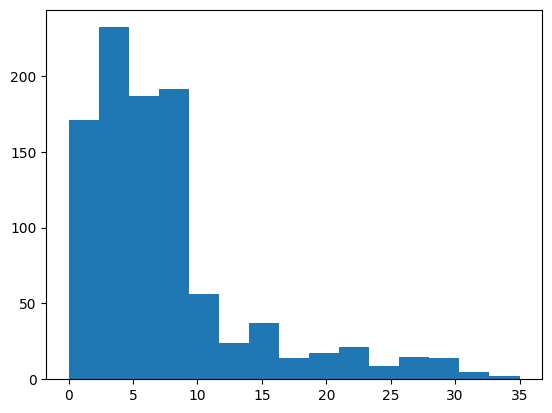

In [69]:
plt.hist(dataLen, bins=15)
plt.show()

In [70]:
## 기준 길이 (가장 긴 길이)
MAX_LENGTH = max(dataLen)
MAX_LENGTH

35

In [71]:
### [1] 가장 긴 문장 길이 기준
for idx, sent in enumerate(encodingData):
    cur_length=len(sent)
    if cur_length < MAX_LENGTH:
        # sent=sent+([0] * (MAX_LENGTH-cur_length)) # 짧은 만큼 0으로 채워줘야함.
        encodingData[idx]=sent+([0] * (MAX_LENGTH-cur_length)) # enumerate로 index 접근

In [72]:
for _ in encodingData[:3]: print(len(_), _)

35 [332, 746, 138, 16, 747, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
35 [333, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
35 [748, 749, 750, 751, 752, 753, 754, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
